In [1]:
import numpy as np
import pandas as pd
from matplotlib import font_manager as fm, pyplot as plt, rcParams
import seaborn as sns
plt.style.use('seaborn-colorblind')
helv=fm.FontProperties(fname='helvetica.ttf')
from scipy.stats import *

In [2]:
bmi_gwas = pd.read_table("/oak/stanford/groups/mrivas/ukbb24983/cnv/gwas/9796/24611/white_british/ukb24983_v2.INI21001.cnv.PHENO1.glm.linear", 
                         header=0)
bmi_gwas.rename_axis({"#CHROM":"CHR", "ID":"SNP"}, axis=1, inplace=True)
bmi_gwas.dropna(inplace=True)
bmi_gwas.tail()

,CHR,POS,SNP,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P
7033,22,49874383,22:49840871-49907896_-,N,+,+,ADD,332246,0.077465,0.043194,1.793420,0.072906
7034,22,49874837,22:49840871-49908804_-,N,+,+,ADD,332246,0.041014,0.154703,0.265117,0.790920
7035,22,49875264,22:49840871-49909658_-,N,+,+,ADD,332246,0.356431,0.187196,1.904050,0.056904
7036,22,49875565,22:49843235-49907896_-,N,+,+,ADD,332246,-0.139514,0.255751,-0.545508,0.585405
7037,22,49933861,22:49889954-49977768_-,N,+,+,ADD,332246,0.134048,0.233467,0.574163,0.565858


In [3]:
bmi_burden = pd.read_table("/oak/stanford/groups/mrivas/ukbb24983/cnv/gene_burden_test/9796/24611/white_british/ukb24983_v2.INI21001.cnv-burden.PHENO1.glm.linear", 
                           header=0)
bmi_burden = bmi_burden.merge(pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/cnv/pgen/burden.ac.wb.acount', 
                                            usecols=['ID','ALT_CTS'])).query('ALT_CTS >= 5')
bmi_burden.rename_axis({"#CHROM":"CHR", "ID":"GENE"}, axis=1, inplace=True)
bmi_burden.dropna(inplace=True)
bmi_burden.tail()

,CHR,POS,GENE,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ALT_CTS
23593,22,51063891,ARSA,N,+,+,ADD,332486,1.585440,0.909142,1.743880,0.081180,27
23594,22,51142354,SHANK3,N,+,+,ADD,332486,-0.168162,0.324247,-0.518623,0.604024,215
23595,22,51180189,ACR,N,+,+,ADD,332486,-0.410771,0.668971,-0.614035,0.539193,51
23596,22,51214003,RABL2B,N,+,+,ADD,332486,0.493535,1.262720,0.390849,0.695909,15
23597,22,51216789,RPL23AP82,N,+,+,ADD,332486,0.493535,1.262720,0.390849,0.695909,15


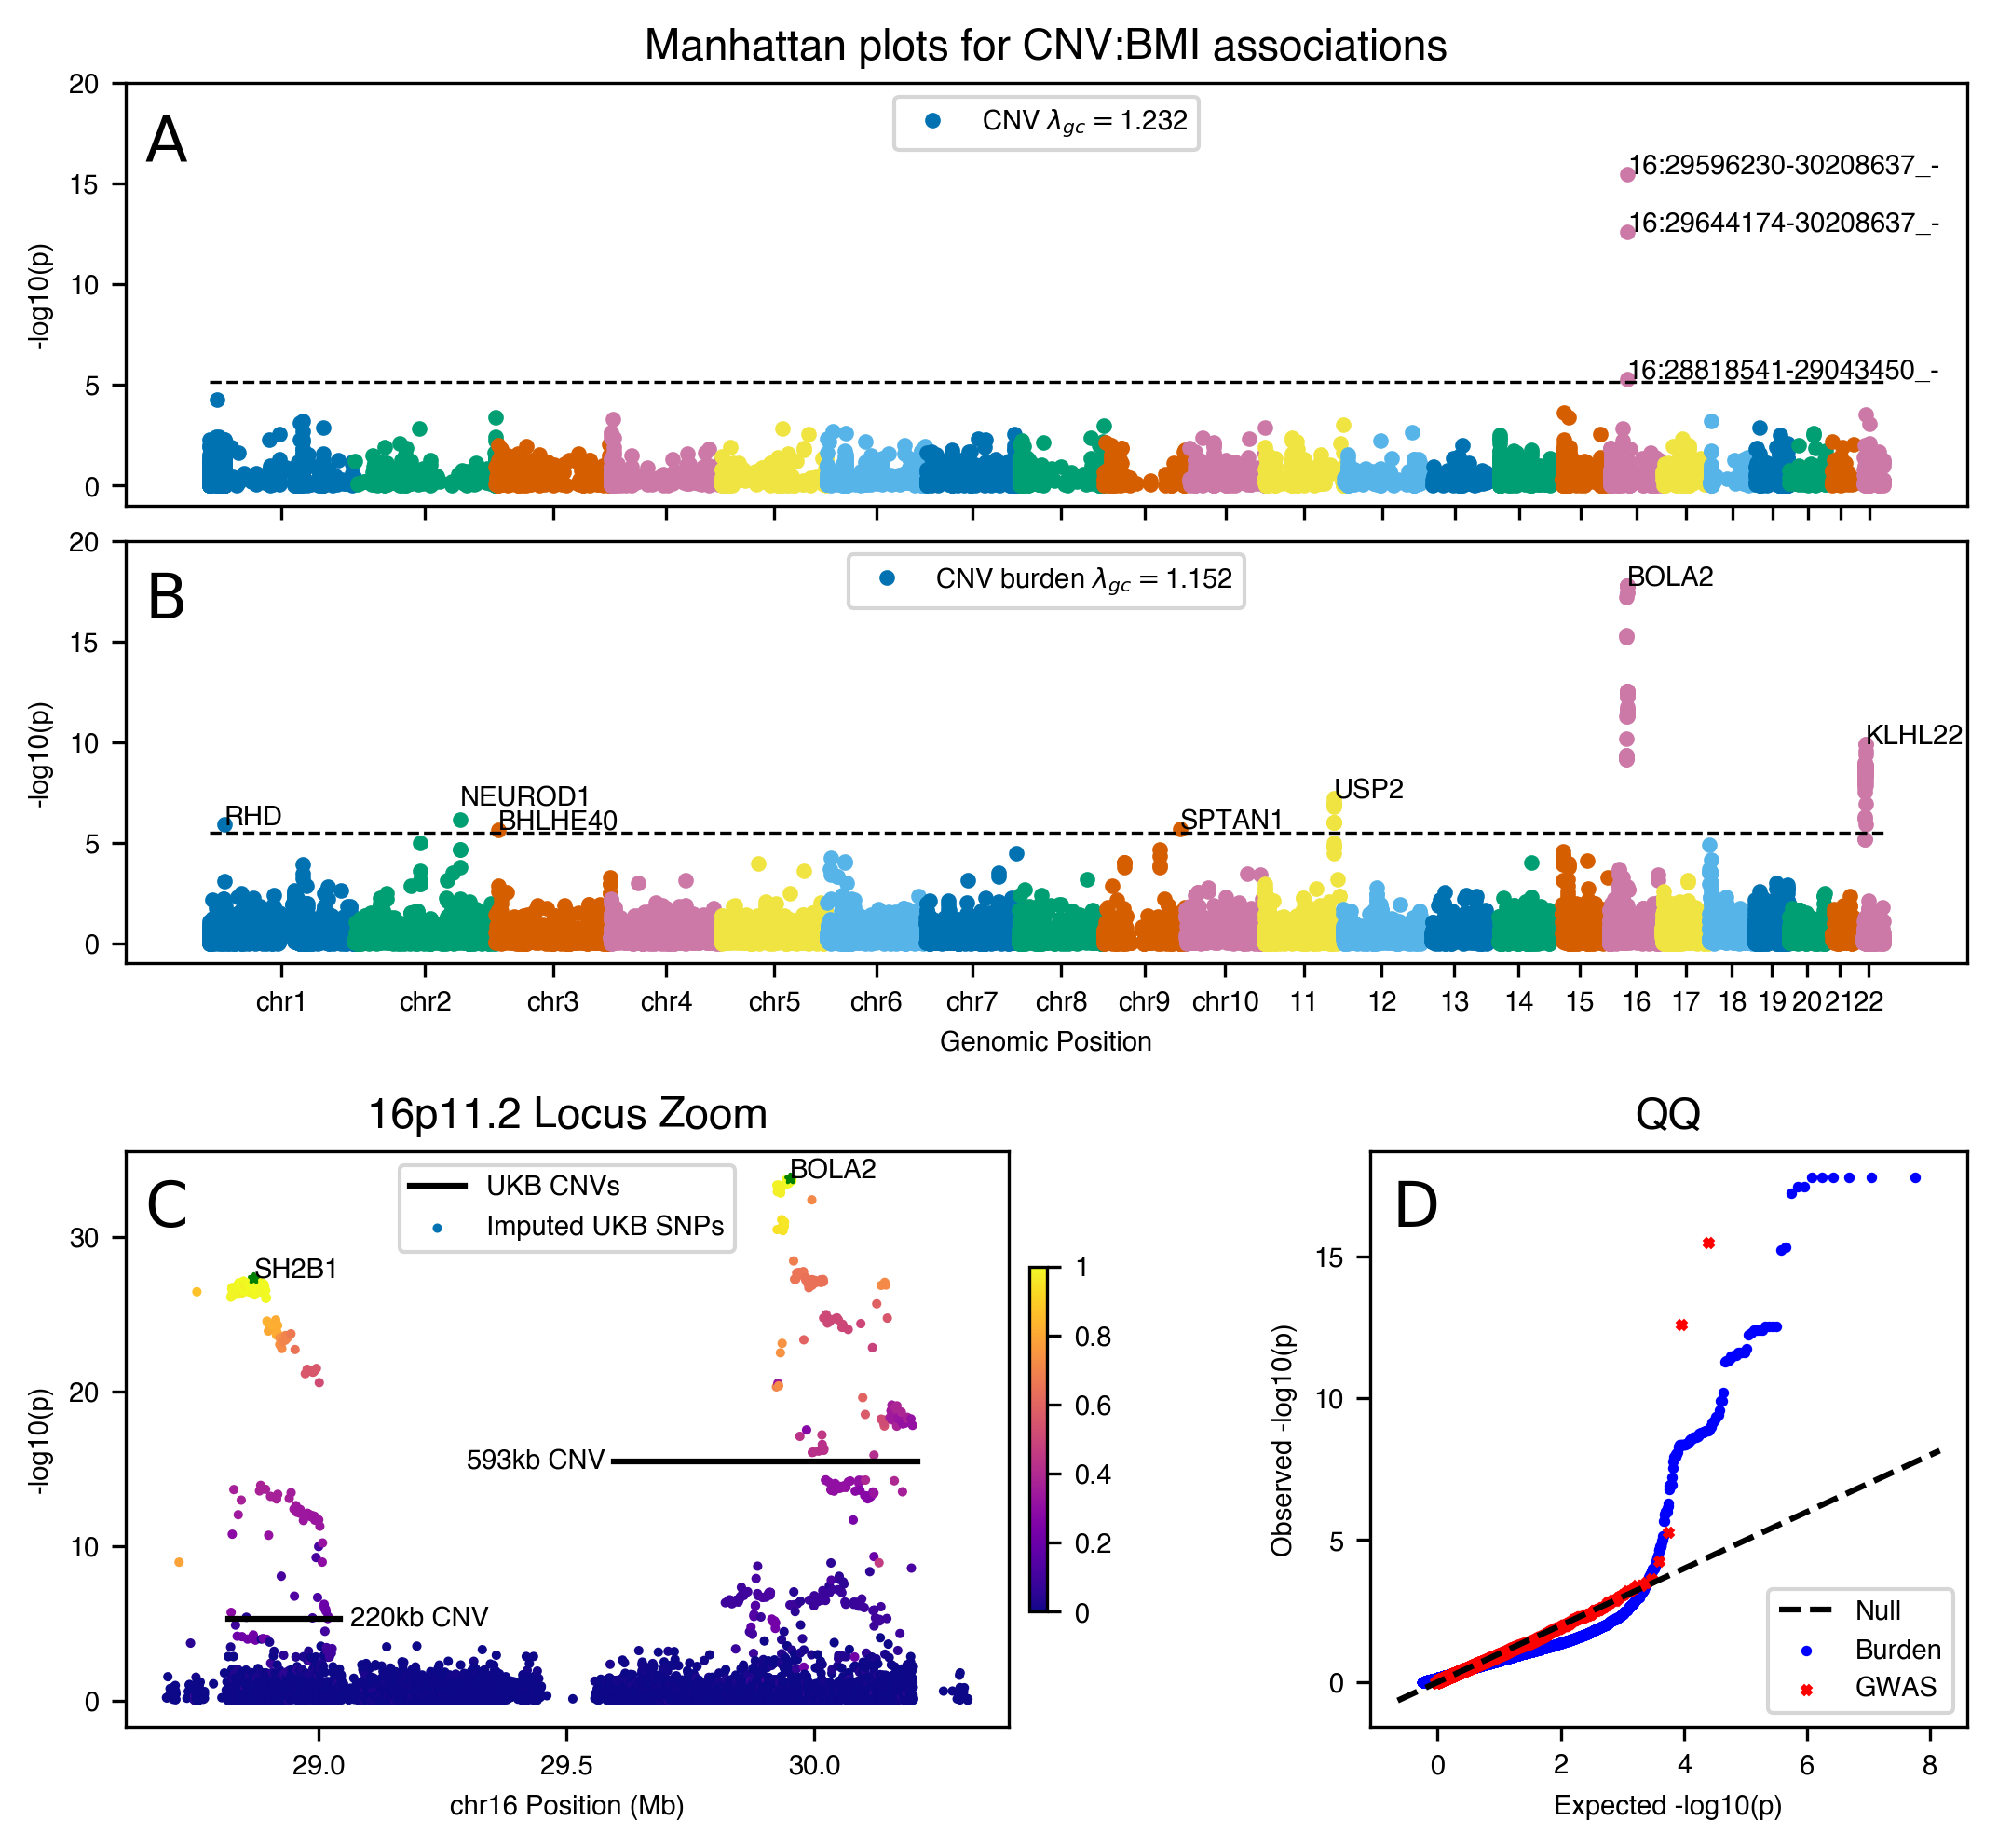

In [4]:
nx,ny=12,11
frac=8.5/12
fig  = plt.figure(figsize=(nx*frac,ny*frac), dpi=300)
grid = plt.GridSpec(ny,nx,hspace=0.3)

# use this for manhattan plot
chrsize = {'1': 249250621,
           '2': 243199373,
           '3': 198022430,
           '4': 191154276,
           '5': 180915260,
           '6': 171115067,
           '7': 159138663,
           '23': 155270560, # X
           '8': 146364022,
           '9': 141213431,
           '10':135534747,
           '11':135006516,
           '12':133851895,
           '13':115169878,
           '14':107349540,
           '15':102531392,
           '16':90354753,
           '17':81195210,
           '18':78077248,
           '20':63025520,
           '24': 59373566, # Y
           '19':59128983,
           '22':51304566,
           '21':48129895}

#######################
# A: Traditional GWAS #
#######################
fig.add_subplot(grid[:3,:])

chrlentot = np.cumsum([0]+[chrsize[str(i)] for i in range(1,25) ])
chrbase = {str(c):chrlentot[i] for i,c in enumerate(list(range(1,23)) + ['X','Y'])}

# plot
bmi_gwas['X'] = bmi_gwas['CHR'].apply(lambda i: chrbase[str(int(i))]) + bmi_gwas['POS']
for c in range(1,23):
    plt.plot(bmi_gwas.loc[bmi_gwas['CHR'] == c, 'X'],
             bmi_gwas.loc[bmi_gwas['CHR'] == c, 'P'].apply(lambda x:-np.log10(x)), '.')

# add significance line
p_star = 0.05/bmi_gwas.shape[0]
# p_star = max([p for i,p in enumerate(sorted(bmi_gwas['P'].values)) if p < (0.05*(i+0.5))/bmi_gwas.shape[0]])
mlp_star = -np.log10(p_star)
plt.plot([bmi_gwas['X'].min(), bmi_gwas['X'].max()], [mlp_star, mlp_star], 
         'k--', linewidth=0.8)

# annotate significant variants
for [n,x,p] in bmi_gwas[bmi_gwas['P'] < p_star].loc[:,['SNP','X','P']].values.tolist():
    plt.annotate(n, [x, -np.log10(p)], fontsize=7, fontproperties=helv)

# labels
plt.title('Manhattan plots for CNV:BMI associations', fontproperties=helv, fontsize=11)
plt.yticks(fontproperties=helv, fontsize=7)
plt.xticks([chrlentot[c] + (chrlentot[c+1]-chrlentot[c])/2 for c in range(22)], 
           ['' for _ in range(22)], fontproperties=helv)
plt.legend([''.join(['CNV ', '$\lambda_{gc}=$', 
                    '{:.3f}'.format(np.median(1-chi2.ppf(bmi_gwas['P'].values, 1))/chi2.ppf(0.5,1))])],
           loc=9, fontsize=7, prop=helv)
plt.ylim((-1,20))
plt.ylabel('-log10(p)', fontproperties=helv)

##################
# B: Burden Test #
##################

fig.add_subplot(grid[3:6,:])

# compute x-positions for plot
bmi_burden['X'] = bmi_burden['CHR'].apply(lambda i: chrbase[str(int(i))]) + bmi_burden['POS']

# plot the points
for c in range(1,23):
    plt.plot(bmi_burden.loc[bmi_burden['CHR'] == c, 'X'],
             bmi_burden.loc[bmi_burden['CHR'] == c, 'P'].apply(lambda x:-np.log10(x)), '.')

# add significance line
p_star_b = 0.05/bmi_burden.shape[0]
mlp_star = -np.log10(p_star_b)
plt.plot([bmi_burden['X'].min(), bmi_burden['X'].max()], [mlp_star, mlp_star], 
         'k--', linewidth=0.8)
    
# annotate significant points (one per chrom)
chr_seen = []
for [c,n,x,p] in bmi_burden[bmi_burden['P'] < p_star_b].loc[:,['CHR','GENE','X','P']].sort_values('P').values.tolist():
    if c not in chr_seen:
        if c == 16 and n != "BOLA2": # several tied lead variants
            continue
        pad=0.7*int(n == 'NEUROD1')
        plt.annotate(n, [x, -np.log10(p) + pad], fontsize=7, fontproperties=helv)
        chr_seen.append(c)

# labels
plt.xlabel('Genomic Position', fontproperties=helv)
plt.xticks([chrlentot[c] + (chrlentot[c+1]-chrlentot[c])/2 for c in range(22)], 
           ['chr{}'.format(c+1) if c < 10 else str(c+1) for c in range(22)],
          fontsize=7, fontproperties=helv)
plt.yticks(fontsize=7, fontproperties=helv)
plt.legend([''.join(['CNV burden ', '$\lambda_{gc}=$',
                     '{:.3f}'.format(np.median(chi2.ppf(1-bmi_burden['P'].values, 1))/chi2.ppf(0.5,1))])],
           loc=9, fontsize=7, prop=helv)
plt.ylim((-1,20))
plt.ylabel('-log10(p)', fontproperties=helv)

#################
# C: Locus Zoom #
#################
ax = fig.add_subplot(grid[7:,:7])

# define region, files
bp1=28700000
bp2=30300000
f='../../../cnv_ukb/ukb_imp_stats/ukb_imp_chr16_bmi_norm_gwas.PHENO1.glm.linear'
r_sh2b1='../../../cnv_ukb/ukb_imp_stats/sh2b1_lead_var_bmi_norm_wb_hrc_r2.ld'
r_taok2='../../../cnv_ukb/ukb_imp_stats/tmem219_lead_var_bmi_norm_wb_hrc_r2.ld'

# load snps, subset to hrc by way of estimated r^2 with clumped variants
snps=pd.read_table(f).dropna().query('POS < @bp2 + 10000 and POS > @bp1-10000')
snps['mlog10p'] = snps['P'].apply(lambda x:-np.log10(x))
r_sh2b1 = pd.read_table(r_sh2b1, usecols=['SNP_B', 'R2'], sep='\s+').rename_axis({'SNP_B':'ID', 'R2':'R2_SH2B1'}, 
                                                                                  axis=1)
r_taok2 = pd.read_table(r_taok2, usecols=['SNP_B', 'R2'], sep='\s+').rename_axis({'SNP_B':'ID', 'R2':'R2_TMEM219'}, 
                                                                                  axis=1)
snps = snps.merge(r_sh2b1, how='outer')
snps = snps.merge(r_taok2, how='outer')
snps['R2'] = snps[['R2_SH2B1','R2_TMEM219']].max(axis=1)
snps = snps.dropna(subset=['R2'])
snps['POS'] = snps['POS'] * 1e-6
# plot everything, then do special labels for lead variants
r2color = plt.scatter(snps['POS'], snps['mlog10p'], s=2, c=snps['R2'], cmap='plasma')
special = snps.query('R2 == 1')
for i,row in special.iterrows():
    plt.scatter([row['POS']], [row['mlog10p']], s=5, c='green', marker='*')
    # in spite of the variable name, the TMEM variant (rs12716975) is an intronic cis-eQTL for BOLA2:
    # http://eqtl.rc.fas.harvard.edu/eqtlbrowser/mrcau133list/10113
    gene = 'SH2B1' if row['ID'] == '16:28868962_C_G' else 'BOLA2'
    plt.annotate(gene, [row['POS'], row['mlog10p']], fontsize=7, fontproperties=helv)    

# add CNV
lpad=0.297000
hpad=0.5
plt.plot([28.818541, 29.043450], [-np.log10(5.087900e-06), -np.log10(5.087900e-06)], 'k-')

# legends and info
plt.annotate('220kb CNV', [29.043450+0.02, -np.log10(5.087900e-06) - hpad], fontsize=7, fontproperties=helv)
plt.legend(['UKB CNVs', 'Imputed UKB SNPs'], loc=9, fontsize=7, prop=helv)
cb=plt.colorbar(r2color, pad=0.02, shrink=0.6)
cb.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=7, fontproperties=helv)
plt.plot([29.596230, 30.208637], [-np.log10(3.357230e-16), -np.log10(3.357230e-16)], 'k-')
plt.annotate('593kb CNV', [29.596230 - lpad, -np.log10(3.357230e-16) - hpad], 
             fontsize=7, fontproperties=helv)

# labels
plt.ylabel('-log10(p)', fontproperties=helv)
plt.xlabel('chr16 Position (Mb)', fontproperties=helv)
plt.yticks(fontsize=7, fontproperties=helv)
plt.xticks(fontsize=7, fontproperties=helv)
plt.title('16p11.2 Locus Zoom', fontsize=11, fontproperties=helv)

##################
# D: QQ for GWAS #
##################
ax = fig.add_subplot(grid[7:,8:])

qq1,l1 = probplot(-np.log10(bmi_gwas['P'].values), dist=expon) #, plot=ax, markersize=2)
qq2,l2 = probplot(-np.log10(bmi_burden['P'].values), dist=expon)
for qq,l,m,s,c in [(qq2,l2,'o',3,'b'), (qq1,l1,'x',5,'r')]:
    plt.scatter(qq[0]*l[0] + l[1],qq[1],s=s,marker=m,color=c)
plt.plot(ax.get_xlim(),ax.get_xlim(),'k--')

# labels
plt.legend(['Null','Burden','GWAS'],fontsize=7,loc=4,prop=helv)
plt.ylabel('Observed -log10(p)', fontproperties=helv)
plt.xlabel('Expected -log10(p)', fontproperties=helv)
plt.yticks(fontsize=7, fontproperties=helv)
plt.xticks(fontsize=7, fontproperties=helv)
plt.title('QQ', fontproperties=helv, fontsize=11)

# add labels
fig.text(0.133, 0.844, 'A', fontsize=16)
fig.text(0.133, 0.634, 'B', fontsize=16)
fig.text(0.133, 0.355, 'C', fontsize=16)
fig.text(0.658, 0.355, 'D', fontsize=16)

# done
plt.savefig('output/Figure3.pdf')
plt.show()

In [5]:
bmi_gwas.query('P < 8e-6').head()

,CHR,POS,SNP,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,X
5628,16,28930996,16:28818541-29043450_-,N,+,+,ADD,332246,0.922206,0.202185,4.56121,5.087900e-06,2438748107
5629,16,29902433,16:29596230-30208637_-,N,+,+,ADD,332246,1.347050,0.165077,8.16016,3.357230e-16,2439719544
5631,16,29926406,16:29644174-30208637_-,N,+,+,ADD,332246,1.871870,0.255729,7.31973,2.490340e-13,2439743517


In [6]:
bmi_burden.query('CHR == "16" & P < 1e-10').sort_values('POS').head()

,CHR,POS,GENE,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ALT_CTS,X
18005,16,29624730,SLC7A5P1,N,+,+,ADD,332486,2.81809,0.431316,6.53371,6.425040e-11,121,2439441841
18006,16,29678046,SPN,N,+,+,ADD,332486,3.11856,0.361361,8.63004,6.159260e-18,172,2439495157
18007,16,29699877,QPRT,N,+,+,ADD,332486,2.86669,0.353202,8.11630,4.822490e-16,180,2439516988
18008,16,29755562,C16orf54,N,+,+,ADD,332486,2.76456,0.341936,8.08502,6.235800e-16,192,2439572673
18009,16,29791264,ZG16,N,+,+,ADD,332486,2.21996,0.321645,6.90189,5.140530e-12,218,2439608375


In [7]:
bmi_burden.query('CHR == "16" & 28200000 < POS & POS < 29000000').sort_values('P').head(10)

,CHR,POS,GENE,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ALT_CTS,X
17991,16,28841463,ATXN2L,N,+,+,ADD,332486,0.852843,0.406645,2.09727,0.035970,135,2438658574
17993,16,28855730,TUFM,N,+,+,ADD,332486,0.843466,0.406647,2.07420,0.038062,135,2438672841
18002,16,28999125,LAT,N,+,+,ADD,332486,0.833732,0.408158,2.04267,0.041086,134,2438816236
17992,16,28855283,MIR4721,N,+,+,ADD,332486,0.815937,0.408161,1.99906,0.045603,134,2438672394
18001,16,28990982,SPNS1,N,+,+,ADD,332486,0.795793,0.403667,1.97141,0.048678,137,2438808093
17995,16,28890759,LOC100289092,N,+,+,ADD,332486,0.719725,0.399321,1.80237,0.071488,140,2438707870
17999,16,28969942,MIR4517,N,+,+,ADD,332486,0.710571,0.399323,1.77944,0.075168,140,2438787053
17994,16,28880305,SH2B1,N,+,+,ADD,332486,0.692948,0.396505,1.74764,0.080527,142,2438697416
18000,16,28970042,NFATC2IP,N,+,+,ADD,332486,0.664140,0.397904,1.66910,0.095099,141,2438787153
17996,16,28902819,ATP2A1,N,+,+,ADD,332486,0.623343,0.395114,1.57763,0.114652,143,2438719930


In [8]:
bmi_gwas.sort_values('P').head()

,CHR,POS,SNP,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,X
5629,16,29902433,16:29596230-30208637_-,N,+,+,ADD,332246,1.347050,0.165077,8.16016,3.357230e-16,2439719544
5631,16,29926406,16:29644174-30208637_-,N,+,+,ADD,332246,1.871870,0.255729,7.31973,2.490340e-13,2439743517
5628,16,28930996,16:28818541-29043450_-,N,+,+,ADD,332246,0.922206,0.202185,4.56121,5.087900e-06,2438748107
215,1,12951972,1:12865657-13038285_+,N,+,+,ADD,332246,-0.815379,0.202185,-4.03284,5.511870e-05,12951972
5180,15,22922033,15:22750297-23093770_+,N,+,+,ADD,332246,0.415476,0.112887,3.68047,2.328440e-04,2330207752


In [9]:
bmi_burden.query('CHR==11').sort_values('P').head()

,CHR,POS,GENE,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ALT_CTS,X
13979,11,119239180,USP2,N,+,+,ADD,332486,10.4342,1.92828,5.41117,6.265650e-08,6,1935147070
13967,11,118982946,C2CD2L,N,+,+,ADD,332486,10.2308,1.92830,5.30563,1.123580e-07,6,1934890836
13966,11,118969998,DPAGT1,N,+,+,ADD,332486,10.2308,1.92830,5.30563,1.123580e-07,6,1934877888
13965,11,118965380,H2AFX,N,+,+,ADD,332486,10.2308,1.92830,5.30563,1.123580e-07,6,1934873270
13968,11,118998998,HINFP,N,+,+,ADD,332486,10.2308,1.92830,5.30563,1.123580e-07,6,1934906888


In [10]:
hits = ['BHLHE40','USP2','SPTAN1','NEUROD1','KLHL22']
bmi_burden.query('GENE in @hits').sort_values('P')

,CHR,POS,GENE,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ALT_CTS,X
23115,22,20822987,KLHL22,N,+,+,ADD,332486,1.76057,0.273477,6.43773,1.214340e-10,300,2850551707
13979,11,119239180,USP2,N,+,+,ADD,332486,10.43420,1.928280,5.41117,6.265650e-08,6,1935147070
3568,2,182543112,NEUROD1,N,+,+,ADD,332486,9.55219,1.928430,4.95335,7.298280e-07,6,431793733
11456,9,131355390,SPTAN1,N,+,+,ADD,332486,9.14689,1.928520,4.74295,2.107190e-06,6,1670515102
4035,3,5023980,BHLHE40,N,+,+,ADD,332486,6.20293,1.310070,4.73480,2.193570e-06,13,497473974


In [11]:
bmi_burden.sort_values('P').head(20)

,CHR,POS,GENE,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ALT_CTS,X
18039,16,30210700,SLX1B-SULT1A4,N,+,+,ADD,332486,3.42012,0.389727,8.77568,1.706560e-18,149,2440027811
18037,16,30207024,SLX1B,N,+,+,ADD,332486,3.42012,0.389727,8.77568,1.706560e-18,149,2440024135
18035,16,30204940,BOLA2B,N,+,+,ADD,332486,3.42012,0.389727,8.77568,1.706560e-18,149,2440022051
18038,16,30207025,SLX1A,N,+,+,ADD,332486,3.42012,0.389727,8.77568,1.706560e-18,149,2440024136
18040,16,30210701,SLX1A-SULT1A3,N,+,+,ADD,332486,3.42012,0.389727,8.77568,1.706560e-18,149,2440027812
18036,16,30204941,BOLA2,N,+,+,ADD,332486,3.42012,0.389727,8.77568,1.706560e-18,149,2440022052
18034,16,30200289,LOC606724,N,+,+,ADD,332486,3.36396,0.387105,8.69005,3.638640e-18,151,2440017400
18033,16,30197563,CORO1A,N,+,+,ADD,332486,3.36396,0.387105,8.69005,3.638640e-18,151,2440014674
18006,16,29678046,SPN,N,+,+,ADD,332486,3.11856,0.361361,8.63004,6.159260e-18,172,2439495157
18007,16,29699877,QPRT,N,+,+,ADD,332486,2.86669,0.353202,8.11630,4.822490e-16,180,2439516988
